In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import category_encoders as ce
import statsmodels.stats.power as smp
from sklearn.preprocessing import MinMaxScaler

df_org = pd.read_csv(r"census_income_original_2.csv")
df = df_org.copy()

C:\Users\t-aelmiggabbar\AppData\Local\Temp\ipykernel_13140\2211330390.py:8: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_org = pd.read_csv(r"census_income_original_2.csv")


In [2]:
# clean
df = df_org.copy()

# combine net gain and loss
df['net_capital'] = df['capital.gain'] + (df['capital.loss']*-1)
#df.drop(columns=['capital.gain', 'capital.loss'], inplace=True)

# encode income
df['income>50k'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# handlin income_value missing values
df['income_value'] = pd.to_numeric(df['income_value'], errors='coerce')
df['income_value_encoded'] = np.where(
    (df['income>50k'] == 1) & (df['income_value'] > 50000), 1,
    np.where(
        (df['income>50k'] == 0) & (df['income_value'] <= 50000), -1,
        0 
    )
)

# handling missing catigorical variables
cont_cols = ['income_value', 'age', 'capital.gain', 'capital.loss', 'hours.per.week', 'net.capital']
cat_cols = ['relationship', 'occupation', 'education', 'marital.status', 'race', 'native.country', 'workclass', 'income_value_encoded']

for col in cat_cols:
    df[col] = df[col].replace('?', np.nan)
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)
#df.drop(columns=[ 'ID', 'education', 'marital.status', 'race', 'native.country', 'workclass', 'income', 'income_value'], inplace=True)
#df.drop(columns=[ 'ID', 'income', 'income_value'], inplace=True)


#encode gender
mapping = {
    'm': 0,'m ': 0,'M': 0,'malee': 0,'male ': 0,'male': 0,'Male': 0,'Female': 1,'female': 1,'f': 1
}
df['Gender'] = df['Gender'].map(mapping)

#df = pd.get_dummies(df, columns=cat_cols)



In [3]:
df.head(5)

,ID,age,workclass,education,education.num,marital.status,occupation,relationship,race,Gender,capital.gain,capital.loss,hours.per.week,native.country,income,income_value,net_capital,income>50k,income_value_encoded
0,1,90,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,1,0,4356,40,United-States,<=50K,7986.0,-4356,0,-1
1,2,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,1,0,4356,18,United-States,<=50K,4566.0,-4356,0,-1
2,3,66,Private,Some-college,10,Widowed,Exec-managerial,Unmarried,Black,1,0,4356,40,United-States,<=50K,2571.0,-4356,0,-1
3,4,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,1,0,3900,40,United-States,<=50K,8611.0,-3900,0,-1
4,5,41,Private,Some-college,10,Separated,"Prof-,specialty",Own-child,White,1,0,3900,40,United-States,<=50K,1553.0,-3900,0,-1


In [20]:


def plot_cont(df, col, bins=20):
    # Calculate Q1, Q3, IQR, and the lower and upper bounds for outliers
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    min_value = df[col].min()
    max_value = df[col].max()
    
    # Freedman-Diaconis bin calculation

    # Calculate outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Get the outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Outliers for {col}:")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    print(f"Number of outliers: {outliers.shape[0]}")

    from scipy.stats import zscore

    df['zscore'] = zscore(df[col])
    outliers = df[df['zscore'].abs() > 3]  # For example, z-scores greater than 3 indicate outliers
    print(f"Number of outliers based on z-score: {outliers.shape[0]}")

    
    # Plotting
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.hist(df[col], bins=bins, edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(df[col])
    plt.title(f"Boxplot of {col}")

    # QQ plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ Plot for {col}")

    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()


In [21]:
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, QuantileTransformer
from scipy.stats.mstats import winsorize


def power_transformation(df, col):
    transformer = PowerTransformer(method='yeo-johnson', standardize=True)    
    transformed_col = transformer.fit_transform(df[[col]])    
    return pd.Series(transformed_col.flatten(), index=df.index)

def rob_sc(df, col):
    scaler = RobustScaler()
    transformed_data = scaler.fit_transform(df[[col]])  
    df[col + '_robust_scaled'] = transformed_data.flatten()  
    return df

def std_sc(df, col):
    scaler = StandardScaler()
    transformed_data = scaler.fit_transform(df[[col]]) 
    df[col + '_std_scaled'] = transformed_data 
    return df


def quantile_transform(df, col):
    transformer = QuantileTransformer(output_distribution='uniform') 
    transformed_data = transformer.fit_transform(df[[col]])
    df[col + '_quantile_transformed'] = transformed_data.flatten()  
    return df


from scipy.stats.mstats import winsorize
def exp(df, col):  
    df[col + '_exp'] = df[col]**2
    return df




Outliers for age:
Lower bound: -2.0, Upper bound: 78.0
Number of outliers: 146
Number of outliers based on z-score: 124


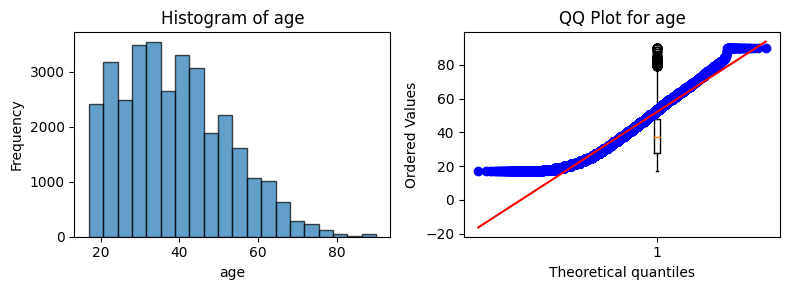

<Figure size 640x480 with 0 Axes>

Outliers for age_quantile_transformed:
Lower bound: -3.0059054386134147, Upper bound: 3.0234738171856885
Number of outliers: 0
Number of outliers based on z-score: 0


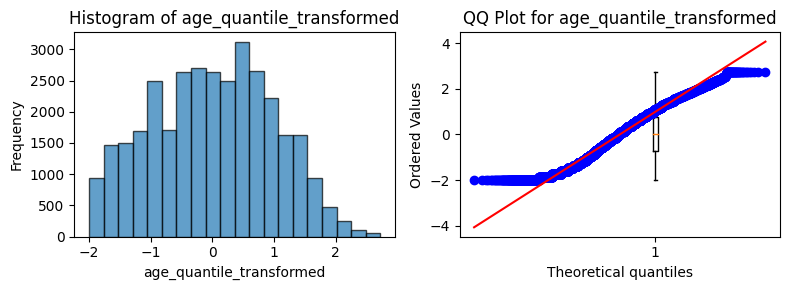

<Figure size 640x480 with 0 Axes>

In [22]:
df['age_power_transformed'] = power_transformation(df, 'age')
df['age_quantile_transformed'] = power_transformation(df, 'age')


plot_cont(df, "age")
plot_cont(df, "age_quantile_transformed")

#plot_cont(df, "age_power_transformed")


Outliers for capital.gain:
Lower bound: 0.0, Upper bound: 0.0
Number of outliers: 2712
Number of outliers based on z-score: 215


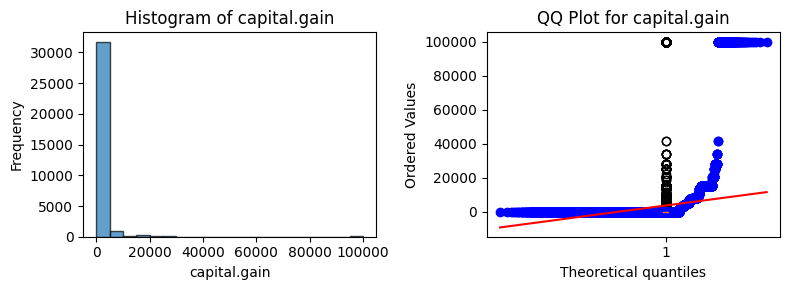

<Figure size 640x480 with 0 Axes>

Outliers for capital.gain_exp:
Lower bound: 0.0, Upper bound: 0.0
Number of outliers: 2712
Number of outliers based on z-score: 159


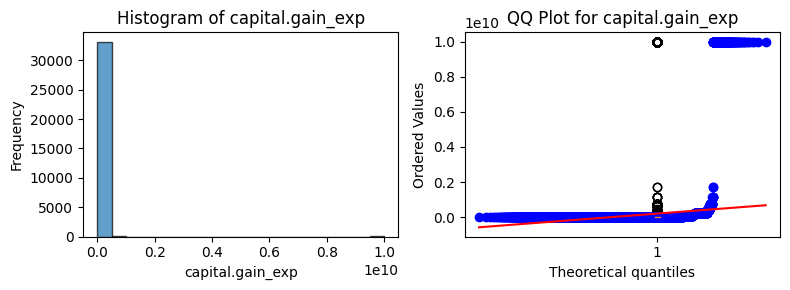

<Figure size 640x480 with 0 Axes>

In [23]:
#df['capital.gain_power_transformed'] = power_transformation(df, 'capital.gain')
df = exp(df, 'capital.gain')
plot_cont(df, "capital.gain")
plot_cont(df, "capital.gain_exp")
#plot_cont(df, "capital.gain_power_transformed")

Outliers for capital.loss:
Lower bound: 0.0, Upper bound: 0.0
Number of outliers: 2291
Number of outliers based on z-score: 1966


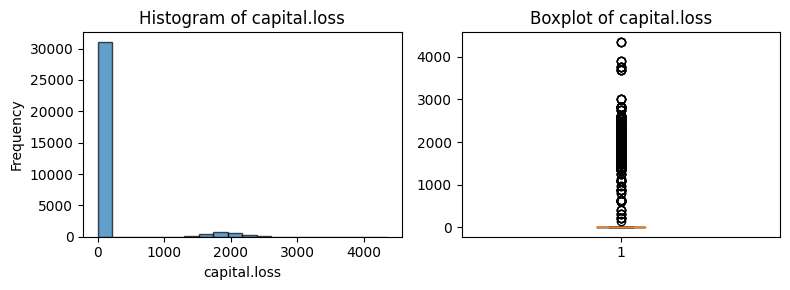

Outliers for capital.loss_power_transformed:
Lower bound: -0.2716675069407227, Upper bound: -0.2716675069407227
Number of outliers: 2291
Number of outliers based on z-score: 2291


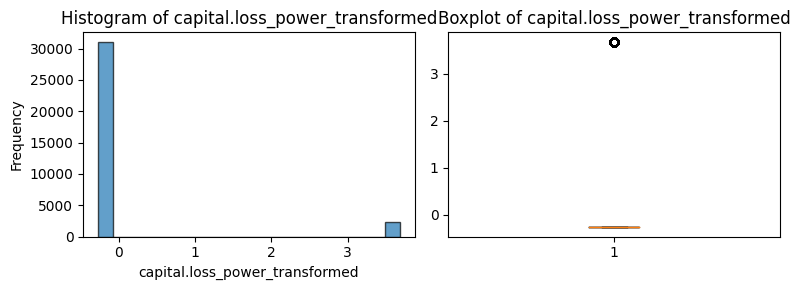

In [8]:
df['capital.loss_power_transformed'] = power_transformation(df, 'capital.loss')
plot_cont(df, "capital.loss")
plot_cont(df, "capital.loss_power_transformed")

Outliers for net_capital:
Lower bound: 0.0, Upper bound: 0.0
Number of outliers: 5003
Number of outliers based on z-score: 215


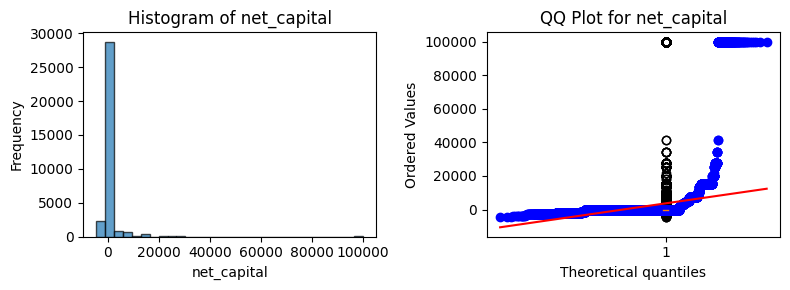

<Figure size 640x480 with 0 Axes>

Outliers for net_capital_power_transformed:
Lower bound: -0.052960079011987446, Upper bound: -0.052960079011987446
Number of outliers: 5003
Number of outliers based on z-score: 650


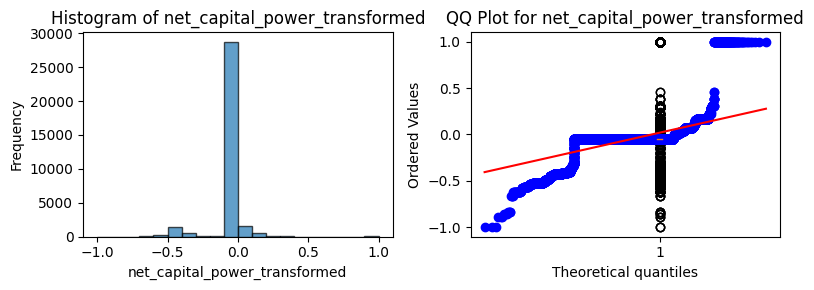

<Figure size 640x480 with 0 Axes>

In [24]:
from sklearn.preprocessing import MinMaxScaler

def rescale_to_minus_one_one(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(data.values.reshape(-1, 1)).flatten()

df['net_capital_power_transformed'] = power_transformation(df, 'net_capital')
df['net_capital_power_transformed'] = rescale_to_minus_one_one(df['net_capital_power_transformed'])

plot_cont(df, "net_capital", 30)
plot_cont(df, "net_capital_power_transformed")




Outliers for net_capital:
Lower bound: 0.0, Upper bound: 0.0
Number of outliers: 5003
Number of outliers based on z-score: 215


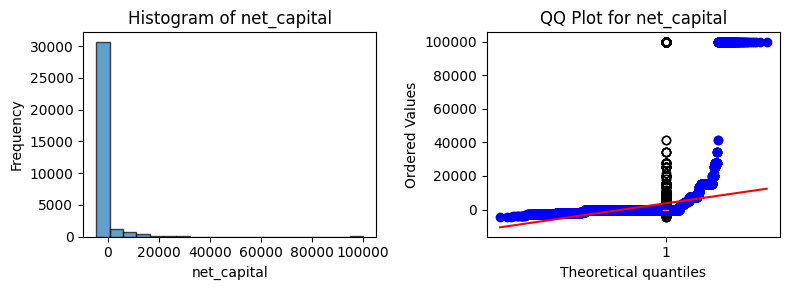

<Figure size 640x480 with 0 Axes>

Outliers for net_capital_std_scaled:
Lower bound: -0.1252501449192194, Upper bound: -0.1252501449192194
Number of outliers: 5003
Number of outliers based on z-score: 215


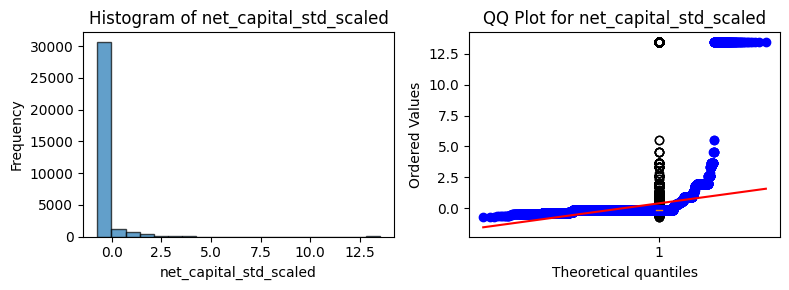

<Figure size 640x480 with 0 Axes>

Outliers for net_capital_quantile_transformed:
Lower bound: 0.08843402468453102, Upper bound: 0.08843402468453102
Number of outliers: 5003
Number of outliers based on z-score: 650


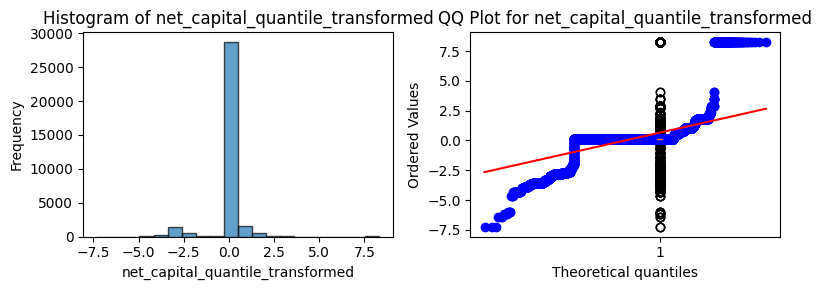

<Figure size 640x480 with 0 Axes>

In [25]:

df = std_sc(df, 'net_capital')
df['net_capital_quantile_transformed'] = power_transformation(df, 'net_capital')

plot_cont(df, "net_capital")
plot_cont(df, "net_capital_std_scaled")
plot_cont(df, "net_capital_quantile_transformed")


Outliers for hours.per.week:
Lower bound: 32.5, Upper bound: 52.5
Number of outliers: 9217
Number of outliers based on z-score: 455


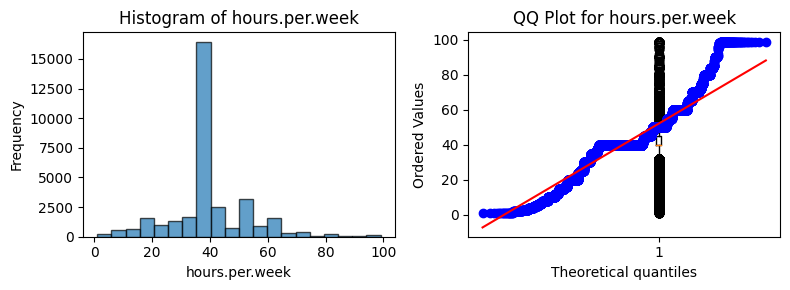

<Figure size 640x480 with 0 Axes>

Outliers for hours.per.week_robust_scaled:
Lower bound: -1.5, Upper bound: 2.5
Number of outliers: 9217
Number of outliers based on z-score: 455


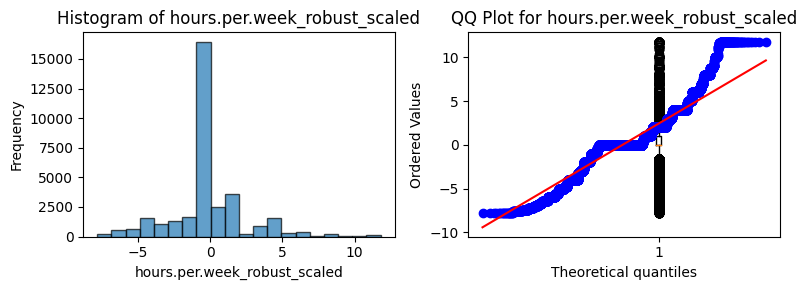

<Figure size 640x480 with 0 Axes>

Outliers for hours.per.week_std_scaled:
Lower bound: -0.6504722966538905, Upper bound: 0.966965097533407
Number of outliers: 9217
Number of outliers based on z-score: 455


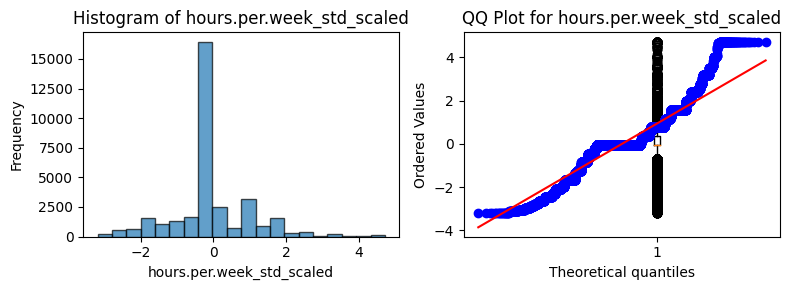

<Figure size 640x480 with 0 Axes>

Outliers for hours.per.week_quantile_transformed:
Lower bound: 0.052302302302302095, Upper bound: 1.1674174174174177
Number of outliers: 1710
Number of outliers based on z-score: 0


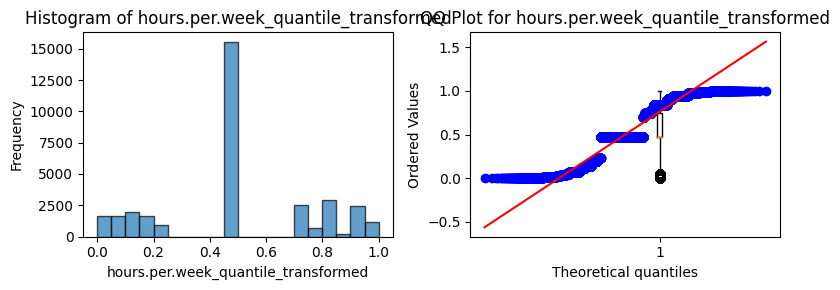

<Figure size 640x480 with 0 Axes>

Outliers for hours.per.week_power_transformed:
Lower bound: -0.6498683986207117, Upper bound: 0.9671193465599889
Number of outliers: 9217
Number of outliers based on z-score: 455


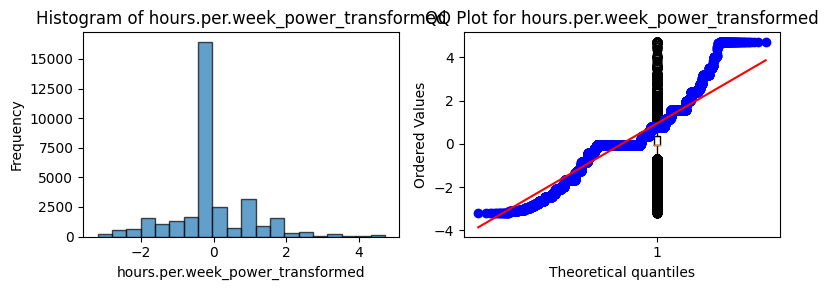

<Figure size 640x480 with 0 Axes>

In [27]:
df = quantile_transform(df, 'hours.per.week')
df = std_sc(df, 'hours.per.week')
df = rob_sc(df, 'hours.per.week')
df['hours.per.week_power_transformed'] = power_transformation(df, 'hours.per.week')
# Now plot the scaled data



plot_cont(df, "hours.per.week")
plot_cont(df, "hours.per.week_robust_scaled")
plot_cont(df, "hours.per.week_std_scaled")
plot_cont(df, "hours.per.week_quantile_transformed")
plot_cont(df, "hours.per.week_power_transformed")




In [33]:
def test_normality(data, column_name):
    stat, p_value = stats.shapiro(data[column_name])
    print(f"Shapiro-Wilk Test for {column_name}:")
    print(f"Statistic: {stat:.4f}, p-value: {p_value:.4f}")
    if p_value > 0.05:
        print(f"The {column_name} follows a normal distribution.\n")
    else:
        print(f"not normal")

test_normality(df, 'age')
test_normality(df, "hours.per.week_robust_scaled")
test_normality(df, "hours.per.week_std_scaled")
test_normality(df, "hours.per.week_quantile_transformed")
test_normality(df, "hours.per.week_power_transformed")

Shapiro-Wilk Test for age:
Statistic: 0.9678, p-value: 0.0000
not normal
Shapiro-Wilk Test for hours.per.week_robust_scaled:
Statistic: 0.8854, p-value: 0.0000
not normal
Shapiro-Wilk Test for hours.per.week_std_scaled:
Statistic: 0.8854, p-value: 0.0000
not normal
Shapiro-Wilk Test for hours.per.week_quantile_transformed:
Statistic: 0.9017, p-value: 0.0000
not normal
Shapiro-Wilk Test for hours.per.week_power_transformed:
Statistic: 0.8855, p-value: 0.0000
not normal


Outliers for age:
Lower bound: -2.0, Upper bound: 78.0
Number of outliers: 146
Number of outliers based on z-score: 124


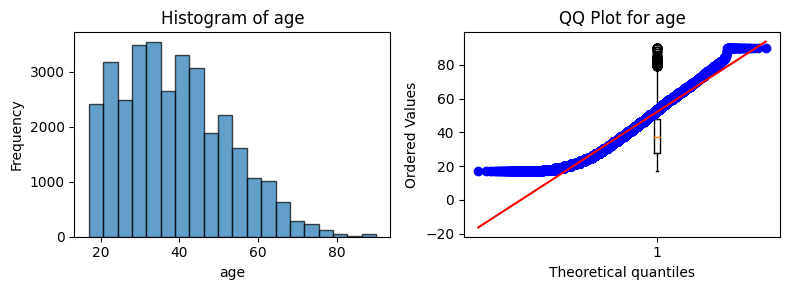

<Figure size 640x480 with 0 Axes>

Outliers for age_robust_scaled:
Lower bound: -1.95, Upper bound: 2.05
Number of outliers: 146
Number of outliers based on z-score: 124


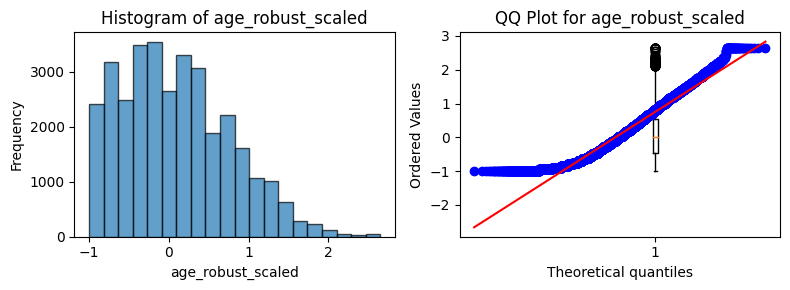

<Figure size 640x480 with 0 Axes>

Outliers for age_std_scaled:
Lower bound: -2.9871701192099427, Upper bound: 2.8827476404786156
Number of outliers: 146
Number of outliers based on z-score: 124


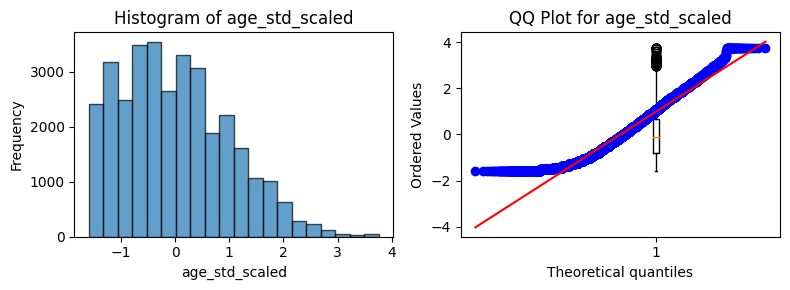

<Figure size 640x480 with 0 Axes>

Outliers for age_quantile_transformed:
Lower bound: -0.4957457457457458, Upper bound: 1.5122622622622623
Number of outliers: 0
Number of outliers based on z-score: 0


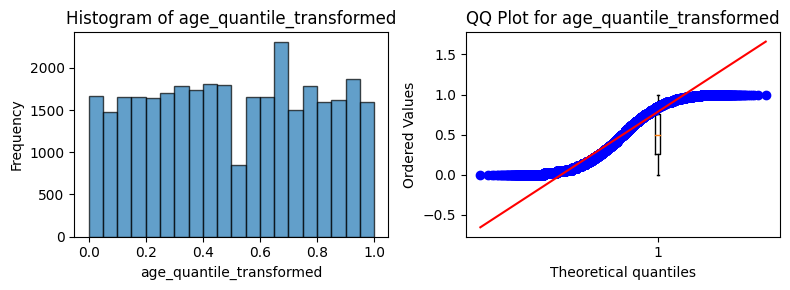

<Figure size 640x480 with 0 Axes>

Outliers for age_power_transformed:
Lower bound: -3.0059054386134147, Upper bound: 3.0234738171856885
Number of outliers: 0
Number of outliers based on z-score: 0


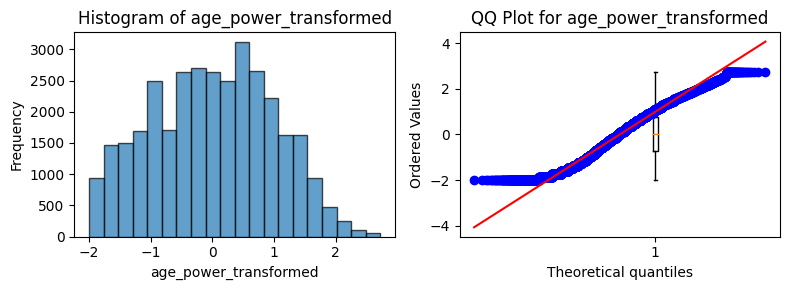

<Figure size 640x480 with 0 Axes>

In [36]:


df = quantile_transform(df, 'age')
df = std_sc(df, 'age')
df = rob_sc(df, 'age')
df['age_power_transformed'] = power_transformation(df, 'age')
plot_cont(df, "age")
plot_cont(df, "age_robust_scaled")
plot_cont(df, "age_std_scaled")
plot_cont(df, "age_quantile_transformed")
plot_cont(df, "age_power_transformed")


C:\Users\t-aelmiggabbar\AppData\Local\anaconda3\envs\task3_env\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Test for hours.per.week:
Statistic: 0.8854, p-value: 0.0000
The hours.per.week does not follow a normal distribution.

Shapiro-Wilk Test for age:
Statistic: 0.9678, p-value: 0.0000
The age does not follow a normal distribution.



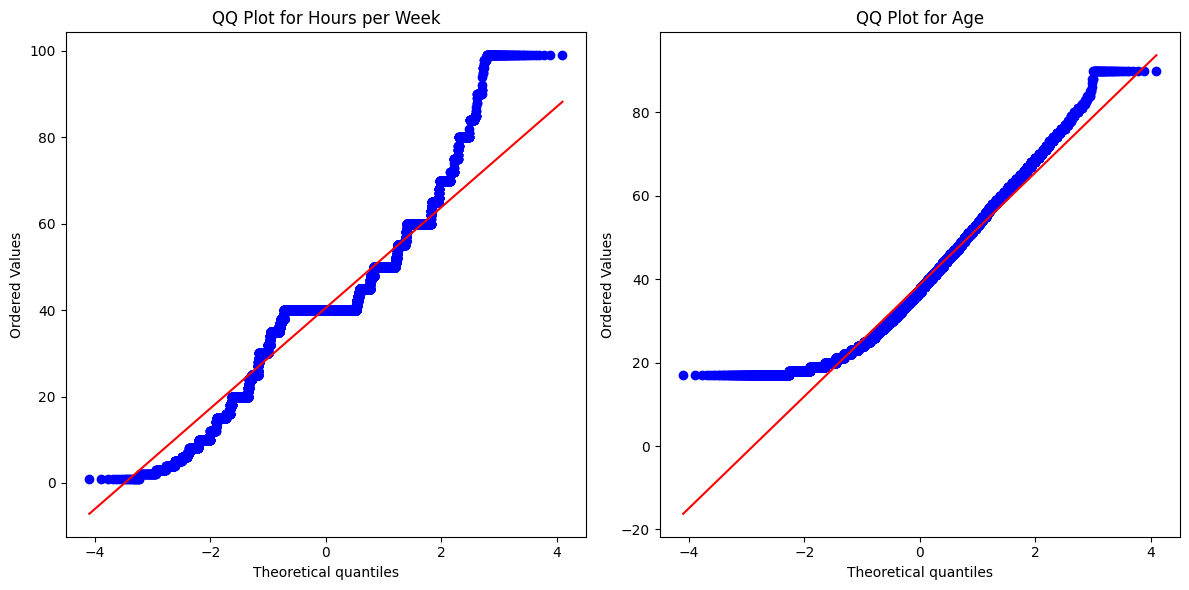

In [37]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame

# Shapiro-Wilk Test for Normality
def test_normality(data, column_name):
    stat, p_value = stats.shapiro(data[column_name])
    print(f"Shapiro-Wilk Test for {column_name}:")
    print(f"Statistic: {stat:.4f}, p-value: {p_value:.4f}")
    if p_value > 0.05:
        print(f"The {column_name} follows a normal distribution.\n")
    else:
        print(f"The {column_name} does not follow a normal distribution.\n")

# Apply test for 'hours.per.week' and 'age'
test_normality(df, 'hours.per.week')
test_normality(df, 'age')

# QQ Plot for 'hours.per.week'
plt.figure(figsize=(12, 6))

# Plot for 'hours.per.week'
plt.subplot(1, 2, 1)
stats.probplot(df['hours.per.week'].dropna(), dist="norm", plot=plt)
plt.title("QQ Plot for Hours per Week")

# Plot for 'age'
plt.subplot(1, 2, 2)
stats.probplot(df['age'].dropna(), dist="norm", plot=plt)
plt.title("QQ Plot for Age")

plt.tight_layout()
plt.show()
